# Experiments

In [35]:
from importlib import reload
import setups
import nn
reload(setups)
reload(nn)

<module 'nn' from '/Users/alice/Documents/GIT/Information-Bottleneck/nn.py'>

In [36]:
import sys
import os
import datetime
from pathlib import Path

import torch

from dataset import *
from mi import *   
from nn import *
from setups import *
from utils import *

In [37]:
setup_idx = 3
verbose = 1
dir = "setup-{}".format(setup_idx)

In [38]:
# Load setup
setup = setup_lookup(setup_idx)

# Directory to save the activations (create the directory if it does not exist)
Path( "./"+dir ).mkdir(parents=True, exist_ok=True) 

# The activations will be saved in a subdirectory unique to this execution
while True:
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    subdir = "activations-{}".format(timestamp)
    try:
        os.mkdir("./"+dir+"/"+subdir)
        break
    except:
            pass
path = "./"+dir+"/"+subdir+"/"

# Load dataset
ratio = setup["train_ratio"]  # ratio of the training set to the test set
if setup["dataset"] == "mnist":
    dataset = buildDatasets( *loadMNISTData(root="data"), ratio=ratio, name="mnist" )
elif setup["dataset"] == "synthetic":
    dataset = buildDatasets( *loadSyntheticData(file="data/synthetic/var_u.mat"), ratio=ratio, name="synthetic" )

loader = buildDataLoader(dataset, batch_size=setup["batch_size"])

# Choose torch device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")     
# print("Using device:", device)

# Train model
save = True
save_interval = 1

model = Network(
        input_dim=dataset["n_features"], 
        hidden_dims=setup["hidden_dims"],
        output_dim=setup["output_dim"],
        hidden_activation_f=setup["hidden_activation_f"],
        output_activation_f=setup["output_activation_f"]
        ).to(device)

optimizer = setup["optimizer"]( model.parameters() )

if save:
    save_setup(setup, path=path, fname="setup")

train_loss = []
test_loss = []
test_acc = []
for epoch in range(1, setup["n_epochs"] + 1):
        train_loss_item = train(model, setup, loader["train"], optimizer, device, epoch, verbose=verbose)
        test_loss_item, test_acc_item = test(model, setup, loader["test"], device, verbose=verbose)
        if save and epoch%save_interval == 0:
                save_activations(model, dataset["full"], epoch, device, path=path)
        train_loss.append(train_loss_item)
        test_loss.append(test_loss_item)
        test_acc.append(test_acc_item)

Epoch 1: train loss 0.7184 -- test loss: 0.7023 -- test acc: 0.5183
Epoch 2: train loss 0.7182 -- test loss: 0.7020 -- test acc: 0.5183
Epoch 3: train loss 0.7178 -- test loss: 0.7017 -- test acc: 0.5183
Epoch 4: train loss 0.7173 -- test loss: 0.7012 -- test acc: 0.5183
Epoch 5: train loss 0.7166 -- test loss: 0.7007 -- test acc: 0.5183
Epoch 6: train loss 0.7158 -- test loss: 0.7002 -- test acc: 0.5183
Epoch 7: train loss 0.7149 -- test loss: 0.6996 -- test acc: 0.5183
Epoch 8: train loss 0.7139 -- test loss: 0.6990 -- test acc: 0.5183
Epoch 9: train loss 0.7128 -- test loss: 0.6983 -- test acc: 0.5183
Epoch 10: train loss 0.7117 -- test loss: 0.6977 -- test acc: 0.5183
Epoch 11: train loss 0.7106 -- test loss: 0.6971 -- test acc: 0.5183
Epoch 12: train loss 0.7095 -- test loss: 0.6964 -- test acc: 0.5183
Epoch 13: train loss 0.7083 -- test loss: 0.6958 -- test acc: 0.5183
Epoch 14: train loss 0.7072 -- test loss: 0.6952 -- test acc: 0.5183
Epoch 15: train loss 0.7060 -- test loss: 0

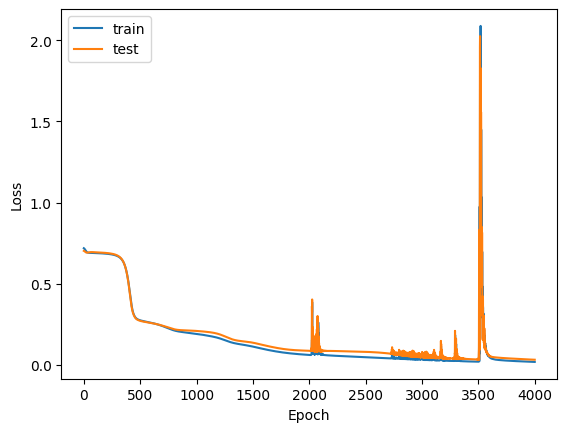

In [39]:
plt.figure()
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(path+"loss.png", dpi=300, bbox_inches="tight")
plt.show()

np.savez_compressed( path+"loss", train_loss=train_loss, test_loss=test_loss, test_acc=test_acc)

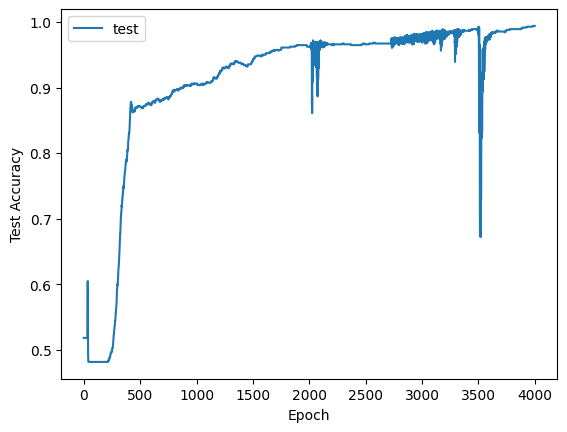

In [40]:
plt.figure()
plt.plot(test_acc, label="test")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig(path+"acc.png", dpi=300, bbox_inches="tight")
plt.show()

In [41]:
mi_xt_epochs, mi_ty_epochs, epochs = compute_mi(dataset["full"], path, interval=1)
np.savez_compressed( path+"mi", mi_xt_epochs=mi_xt_epochs, mi_ty_epochs=mi_ty_epochs, epochs=epochs)

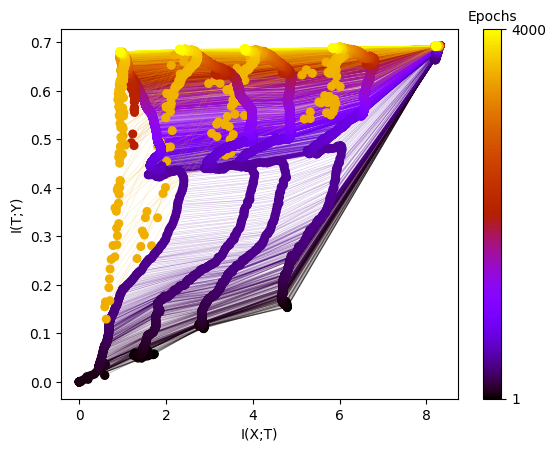

In [42]:
plot_info_plan(mi_xt_epochs, mi_ty_epochs, epochs)
plt.savefig(path+"info-plan.png", dpi=300, bbox_inches="tight")
plt.show()

# Step-by-Step

## PyTorch Device

In [1]:
import torch

In [2]:
# Choose torch device

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print("Using device:", device)

Using device: mps


## Dataset Utils

In [3]:
import dataset
from dataset import *

/Users/alice/Documents/GIT/Information-Bottleneck/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## MI Utils

In [4]:
import mi
from mi import *    

## Neural Network Utils

In [5]:
import nn
from nn import *

## Experiments

In [6]:
# dataset = buildDatasets( *loadMNISTData(root="data"), ratio=6/7, name="mnist" )
dataset = buildDatasets( *loadSyntheticData(file="data/synthetic/var_u.mat"), name="synthetic" )

In [7]:
print( "Number of samples in the training set:", len(dataset["train"]) )
print( "Number of samples in the test set:", len(dataset["test"]) )

Number of samples in the training set: 3276
Number of samples in the test set: 820


In [8]:
# SETTING 1
# - Synthetic dataset
# - Test accuracy: 0.9426

setup = dict()
# network parameters
setup["hidden_dims"] = [10, 7, 5, 4, 3]                         
setup["output_dim"] = 1                                         
setup["hidden_activation_f"] = lambda input: F.tanh(input)      
setup["output_activation_f"] = lambda input: F.sigmoid(input)   

# optimizer
setup["lr"] = 0.01                             
setup["momentum"] = 0.9
setup["optimizer"] = lambda parameters: torch.optim.SGD( parameters, lr=setup["lr"], momentum=setup["momentum"] )

# training configuration
setup["n_epochs"] = 10000
setup["batch_size"] = None
setup["loss_function"] = lambda output, target, reduction='mean': F.binary_cross_entropy(output.reshape(-1), target.float(), reduction=reduction)
setup["evaluate_correct"] = lambda output, target: torch.sum( torch.round(output.reshape(-1)) == target, dtype=torch.float32 )


In [ ]:
# SETTING 2
# - MNIST
# - Test accuracy: 0.9027

setup = dict()
# network parameters
setup["hidden_dims"] = [256, 256, 128]                                          # hidden layers sizes
setup["output_dim"] = 10                                                        # output layer size
setup["hidden_activation_f"] = lambda input: F.tanh(input)                      # activation function for the hidden layers
setup["output_activation_f"] = lambda input: F.log_softmax( input, dim=1 )      # activation function for the output layer

# optimizer
setup["lr"] = 0.01  
setup["optimizer"] = lambda parameters: torch.optim.Adam( parameters, lr=setup["lr"] )       

# training configuration
setup["n_epochs"] = 20
setup["batch_size"] = None
setup["loss_function"] = lambda output, target, reduction='mean': F.nll_loss(output, target, reduction=reduction)
setup["evaluate_correct"] = lambda output, target: torch.sum( output.argmax(dim=1) == target, dtype=torch.float32 )

In [9]:
loader = buildDataLoader(dataset, batch_size=setup["batch_size"])
# batch = next( iter( loader["train"] ) )

In [14]:
save = True
save_interval = 1

for i in range(50):
        model = Network(
                input_dim=dataset["n_features"], 
                hidden_dims=setup["hidden_dims"],
                output_dim=setup["output_dim"],
                hidden_activation_f=setup["hidden_activation_f"],
                output_activation_f=setup["output_activation_f"]
                ).to(device)

        optimizer = setup["optimizer"]( model.parameters() )

        if save:
                folder = save_setup(dataset, setup)

        for epoch in range(1, setup["n_epochs"] + 1):
                train(model, setup, loader["train"], optimizer, device, epoch, verbose=2)
                test(model, setup, loader["test"], device)
                if save and epoch%save_interval == 0:
                        save_activations(model, dataset["full"], epoch, folder, device)

Epoch 1: Batch 1/1: train loss 0.6967 -- test loss: 0.6980 -- test acc: 0.5122

Epoch 2: Batch 1/1: train loss 0.6966 -- test loss: 0.6979 -- test acc: 0.5122

Epoch 3: Batch 1/1: train loss 0.6966 -- test loss: 0.6979 -- test acc: 0.5122

Epoch 4: Batch 1/1: train loss 0.6965 -- test loss: 0.6978 -- test acc: 0.5122

Epoch 5: Batch 1/1: train loss 0.6965 -- test loss: 0.6977 -- test acc: 0.5122

Epoch 6: Batch 1/1: train loss 0.6964 -- test loss: 0.6976 -- test acc: 0.5122

Epoch 7: Batch 1/1: train loss 0.6963 -- test loss: 0.6975 -- test acc: 0.5122

Epoch 8: Batch 1/1: train loss 0.6962 -- test loss: 0.6974 -- test acc: 0.5122

Epoch 9: Batch 1/1: train loss 0.6961 -- test loss: 0.6973 -- test acc: 0.5122

Epoch 10: Batch 1/1: train loss 0.6960 -- test loss: 0.6972 -- test acc: 0.5122

Epoch 11: Batch 1/1: train loss 0.6959 -- test loss: 0.6971 -- test acc: 0.5122

Epoch 12: Batch 1/1: train loss 0.6958 -- test loss: 0.6969 -- test acc: 0.5122

Epoch 13: Batch 1/1: train loss 0.695

In [9]:
folder = "synthetic-20240215-063724"

In [10]:
mi_xt_epochs, mi_ty_epochs, epochs = compute_mi(dataset["full"], folder, interval=1)

In [11]:
# Save MI results as compressed numpy file
path = "./save/"
np.savez_compressed( path+folder+"/mi", mi_xt_epochs=mi_xt_epochs, mi_ty_epochs=mi_ty_epochs, epochs=epochs)

In [ ]:
# Load results
# loaded_results = np.load( path+folder+"/mi.npz" )
# loaded_mi_xt_epochs = loaded_results["mi_xt_epochs"]
# loaded_mi_ty_epochs = loaded_results["mi_ty_epochs"]
# loaded_epochs = loaded_results["epochs"]

In [14]:
from importlib import reload
reload(mi)
from mi import *

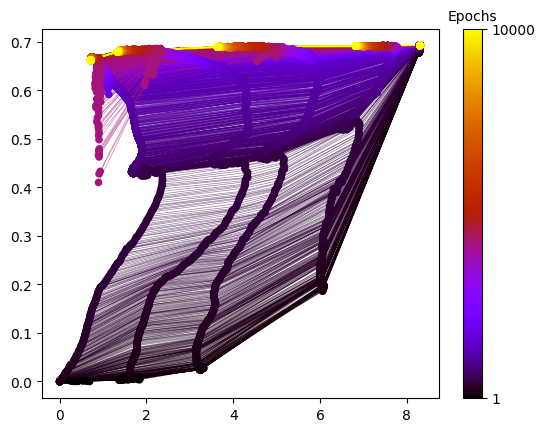

In [15]:
plot_info_plan(mi_xt_epochs, mi_ty_epochs, epochs)